# Spaceship Titanic

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pycaret.classification import setup, compare_models
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

## Loading Data

In [2]:
train0 = pd.read_csv('train.csv')
train0.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
test0 = pd.read_csv('test.csv')
test0.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


### Combining Test and Train Data

In [4]:
target0 = train0['Transported']
target0

0       False
1        True
2       False
3       False
4        True
        ...  
8688    False
8689    False
8690     True
8691    False
8692     True
Name: Transported, Length: 8693, dtype: bool

In [5]:
train0.drop('Transported', axis=1, inplace=True)

In [6]:
data0 = pd.concat([train0, test0], axis=0, ignore_index=True)
data0.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines


In [7]:
data1 = data0.copy()

## Cleaning Data

<AxesSubplot:>

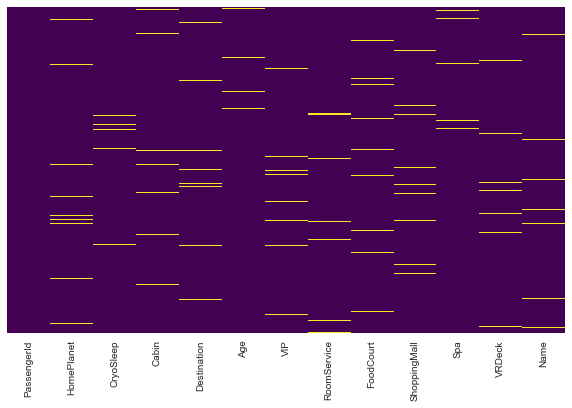

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data1.isnull(), yticklabels=False, cmap='viridis', cbar=False)

In [9]:
# data1['VIP'] = data1['VIP'].astype(bool)

### Seperating PassengerID into GroupNum and PassengerNum

In [10]:
def groupnum(string):
    return string[:4]

def passengernum(string):
    return string[5:]

In [11]:
data1['GroupNum'] = data1['PassengerId'].apply(groupnum).astype(np.int)
data1['PassengerNum'] = data1['PassengerId'].apply(passengernum).astype(np.int)

In [12]:
data1.drop('PassengerId', axis=1, inplace=True)

In [13]:
data1 = data1[['GroupNum', 'PassengerNum', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']]

### Missing HomePlanets

In [14]:
for entry in data1.loc[data1['HomePlanet'].isna(), 'GroupNum']:
    if len(data1.loc[(data1['HomePlanet'].notna()) & (data1['GroupNum'] == entry), 'GroupNum']) > 0:
        data1.loc[(data1['HomePlanet'].isna()) & (data1['GroupNum'] == entry), 'HomePlanet'] = data1.loc[(data1['HomePlanet'].notna()) & (data1['GroupNum'] == entry), 'HomePlanet'].iloc[0]

In [15]:
data1.loc[data1['HomePlanet'].isna(), 'HomePlanet'] = data1['HomePlanet'].mode()[0]

<AxesSubplot:>

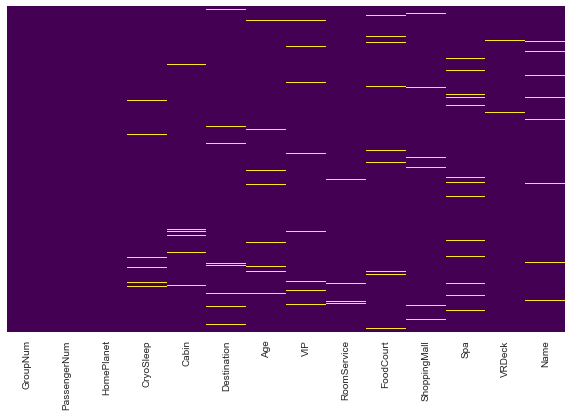

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data1.isnull(), yticklabels=False, cmap='viridis', cbar=False)

In [17]:
data2 = data1.copy()

### Seperating Cabin to Deck, Num and Side

In [18]:
def cabinDeck(string):
    if string == np.nan:
        return None
    else:
        string = str(string).split(sep='/')
        if len(string) > 1:
            return string[0]

def cabinNum(string):
    if string == np.nan:
        return None
    else:
        string = str(string).split(sep='/')
        if len(string) > 1:
            return string[1]

def cabinSide(string):
    if string == np.nan:
        return None
    else:
        string = str(string).split(sep='/')
        if len(string) > 1:
            return string[2]

In [19]:
data2['CabinDeck'] = data2['Cabin'].apply(cabinDeck)
data2['CabinNum'] = data2['Cabin'].apply(cabinNum)
data2['CabinSide'] = data2['Cabin'].apply(cabinSide)

In [20]:
data2.drop('Cabin', axis=1, inplace=True)

In [21]:
data2 = data2[['GroupNum', 'PassengerNum', 'HomePlanet', 'CryoSleep', 'CabinDeck', 'CabinNum', 'CabinSide', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']]

<AxesSubplot:>

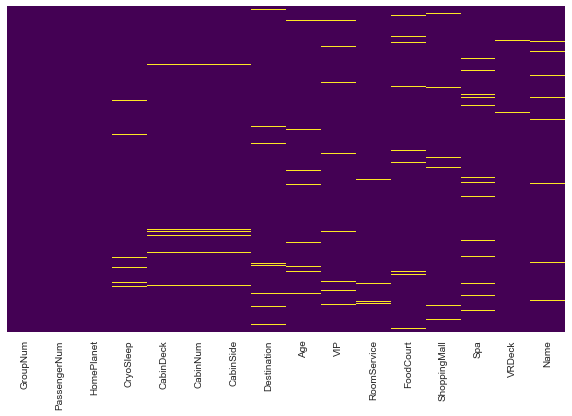

In [22]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data2.isnull(), yticklabels=False, cmap='viridis', cbar=False)

### Missing CryoSleep

In [23]:
data2.loc[:, ['VIP', 'CryoSleep']].value_counts()

VIP    CryoSleep
False  False        7657
       True         4449
True   False         239
       True           28
dtype: int64

In [24]:
data2.loc[data2['CryoSleep'].isna(), 'CryoSleep'] = 'False'

In [25]:
data2['CryoSleep'] = data2['CryoSleep'].astype(bool)

<AxesSubplot:>

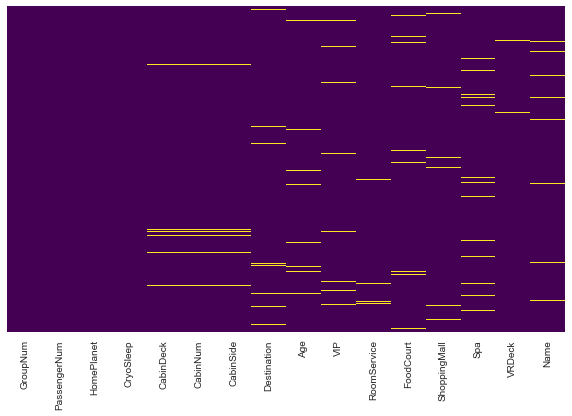

In [26]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data2.isnull(), yticklabels=False, cmap='viridis', cbar=False)

In [27]:
data3 = data2.copy()

### Missing CabinDeck

In [28]:
peopleInAGroup = data3.loc[data3['GroupNum'].duplicated(False), 'GroupNum'].value_counts()
for person in data3.loc[data3['GroupNum'].duplicated(False), 'GroupNum'].index:
    total = peopleInAGroup[data3.loc[person, 'GroupNum']]
    data3.loc[person, 'PeopleInGroup'] = total

data3.loc[data3['PeopleInGroup'].isna(), 'PeopleInGroup'] = 1

<AxesSubplot:xlabel='GroupNum', ylabel='CabinDeck'>

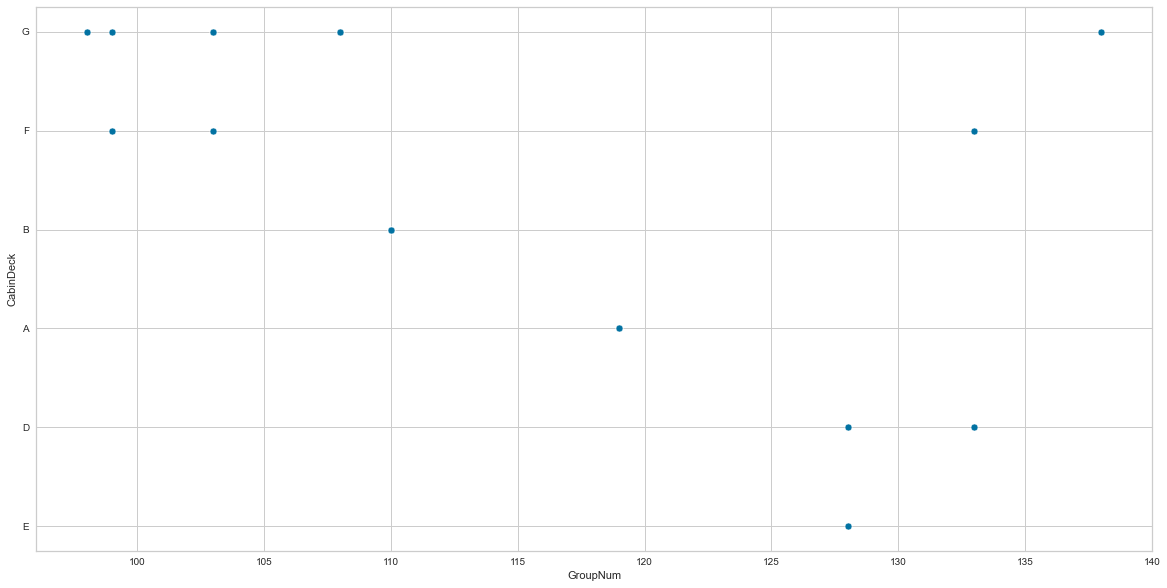

In [29]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=data3.loc[data3['PeopleInGroup'] > 1].loc[data3.loc[data3['PeopleInGroup'] > 1].index[40:60]], x='GroupNum', y='CabinDeck')

In [30]:
data3.loc[data3['PeopleInGroup'] > 1, 'CabinDeck'].isna().sum()

139

In [31]:
data3['CabinDeck'].isna().sum()

299

In [32]:
for person in data3.loc[data3['PeopleInGroup']>1, 'CabinDeck'].isna().loc[data3.loc[data3['PeopleInGroup']>1, 'CabinDeck'].isna()].index:
    gn = data3.loc[person, 'GroupNum']
    cd = data3.loc[data3['CabinDeck'].notna() & (data3['GroupNum'] == gn), 'CabinDeck']
    if len(cd) > 0:
        cd = cd.mode()[0]
        data3.loc[person, 'CabinDeck'] = cd

In [33]:
data3['CabinDeck'].value_counts()

F    4268
G    3821
E    1334
B    1161
C    1122
D     730
A     361
T      11
Name: CabinDeck, dtype: int64

In [34]:
data3.loc[(data3['VIP'] == False), 'CabinDeck'].value_counts()

F    4130
G    3732
E    1284
B    1077
C    1035
D     674
A     305
T      10
Name: CabinDeck, dtype: int64

In [35]:
data3.loc[data3['CabinDeck'].isna() & (data3['VIP'] == True)]

,GroupNum,PassengerNum,HomePlanet,CryoSleep,CabinDeck,CabinNum,CabinSide,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,PeopleInGroup


In [36]:
data3.loc[data3['CabinDeck'].isna(), 'CabinDeck'] = 'F'

<AxesSubplot:>

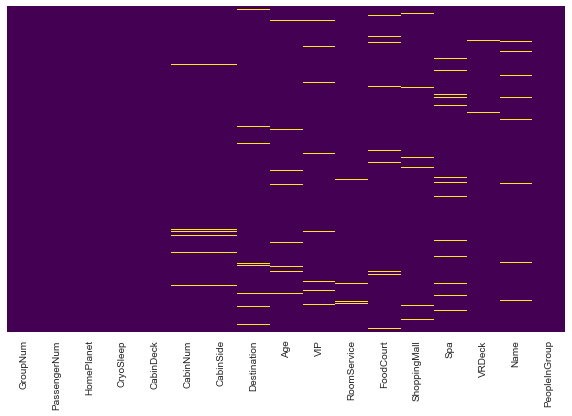

In [37]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data3.isnull(), yticklabels=False, cmap='viridis', cbar=False)

### Missing CabinNum

In [38]:
for person in data3.loc[data3['PeopleInGroup']>1, 'CabinNum'].isna().loc[data3.loc[data3['PeopleInGroup']>1, 'CabinNum'].isna()].index:
    gn = data3.loc[person, 'GroupNum']
    cn = data3.loc[data3['CabinNum'].notna() & (data3['GroupNum'] == gn), 'CabinNum']
    if len(cn) > 0:
        cn = cn.mode()[0]
        data3.loc[person, 'CabinNum'] = cn

In [39]:
data3.loc[data3['CabinDeck'] == 'F', 'CabinNum'] = data3.loc[data3['CabinDeck'] == 'F', 'CabinNum'].fillna(method='ffill')

<AxesSubplot:>

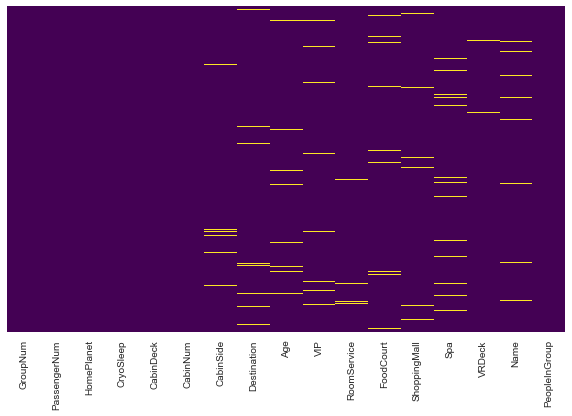

In [40]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data3.isnull(), yticklabels=False, cmap='viridis', cbar=False)

### Missing CabinSide

In [41]:
for person in data3.loc[data3['PeopleInGroup']>1, 'CabinSide'].isna().loc[data3.loc[data3['PeopleInGroup']>1, 'CabinSide'].isna()].index:
    gn = data3.loc[person, 'GroupNum']
    cs = data3.loc[data3['CabinSide'].notna() & (data3['GroupNum'] == gn), 'CabinSide']
    if len(cs) > 0:
        cs = cs.mode()[0]
        data3.loc[person, 'CabinSide'] = cs

In [42]:
data3.loc[(data3['CabinDeck'] == 'F') & (data3['CabinNum'] == '19') & (data3['CabinSide'] == 'P')].shape[0]

1

In [43]:
for person in data3.loc[data3['CabinSide'].isna()].index:
    choices = ['F', 'G', 'E', 'B', 'C', 'D', 'A', 'T']
    deck = data3.loc[person, 'CabinDeck']
    num = data3.loc[person, 'CabinNum']
    if data3.loc[(data3['CabinDeck'] == deck) & (data3['CabinNum'] == num) & (data3['CabinSide'] == 'P')].shape[0] == 0:
        data3.loc[person, 'CabinSide'] = 'P'
    elif data3.loc[(data3['CabinDeck'] == deck) & (data3['CabinNum'] == num) & (data3['CabinSide'] == 'S')].shape[0] == 0:
        data3.loc[person, 'CabinSide'] = 'S'
    else:
        for c in choices:
            if data3.loc[(data3['CabinDeck'] == c) & (data3['CabinNum'] == num) & (data3['CabinSide'] == 'P')].shape[0] == 0:
                data3.loc[person, 'CabinSide'] = 'P'
                break
            elif data3.loc[(data3['CabinDeck'] == c) & (data3['CabinNum'] == num) & (data3['CabinSide'] == 'S')].shape[0] == 0:
                data3.loc[person, 'CabinSide'] = 'S'
                break

<AxesSubplot:>

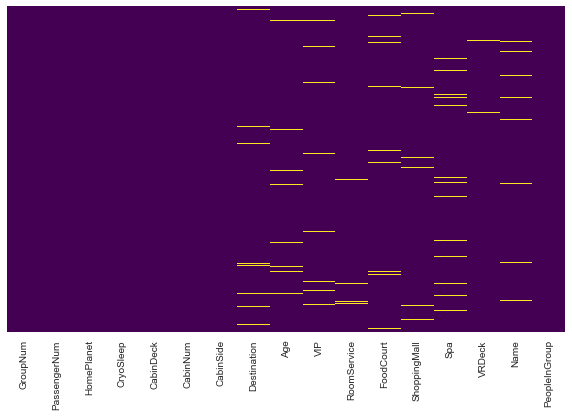

In [44]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data3.isnull(), yticklabels=False, cmap='viridis', cbar=False)

In [45]:
data4 = data3.copy()

### Missing Names

In [46]:
def lastname(string):
    string = str(string).split()
    if len(string) > 1:
        return string[1]

In [47]:
data4['LastName'] = data4['Name'].apply(lastname)

In [48]:
for person in data4.loc[data4['PeopleInGroup'] > 1, 'LastName'].loc[data4.loc[data4['PeopleInGroup'] > 1, 'LastName'].isna()].index:
    gn = data4.loc[person, 'GroupNum']
    cs = data4.loc[data4['LastName'].notna() & (data4['GroupNum'] == gn), 'LastName']
    if len(cs) > 0:
        cs = cs.mode()[0]
        data4.loc[person, 'LastName'] = cs

In [49]:
data4.loc[data4['LastName'].isna(), 'LastName'] = 'Unknown'

In [50]:
data4.drop('Name', axis=1, inplace=True)

<AxesSubplot:>

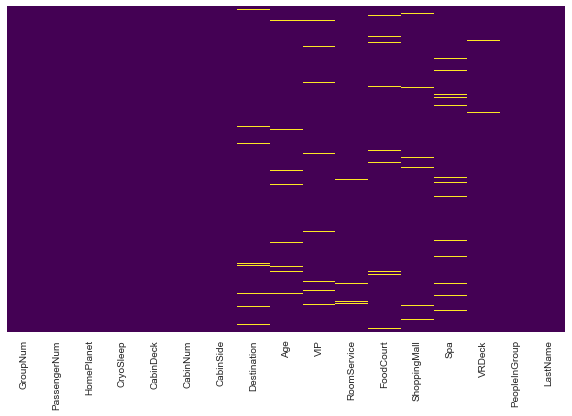

In [51]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data4.isnull(), yticklabels=False, cmap='viridis', cbar=False)

### Missing Destination

In [52]:
data4.loc[data4['Destination'].isna(), 'Destination'] = data4['Destination'].mode()[0]

<AxesSubplot:>

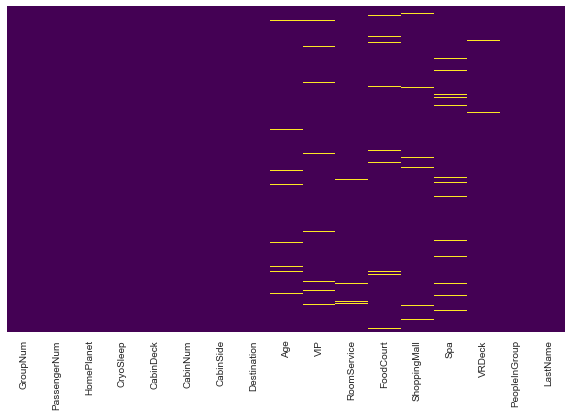

In [53]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data4.isnull(), yticklabels=False, cmap='viridis', cbar=False)

### Missing VIP

In [54]:
data4.loc[((data4['RoomService'] >= data4.loc[(data4['VIP'] == True), 'RoomService'].mean()) | (data4['FoodCourt'] >= data4.loc[(data4['VIP'] == True), 'FoodCourt'].mean()) | (data4['ShoppingMall'] >= data4.loc[(data4['VIP'] == True), 'ShoppingMall'].mean()) | (data4['Spa'] >= data4.loc[(data4['VIP'] == True), 'Spa'].mean()) | (data4['VRDeck'] >= data4.loc[(data4['VIP'] == True), 'VRDeck'].mean())) & (data4['VIP'].isna()) & (data4['Age'] >= 30), 'VIP'] = True

In [55]:
data4['VIP'].fillna(False, inplace=True)

<AxesSubplot:>

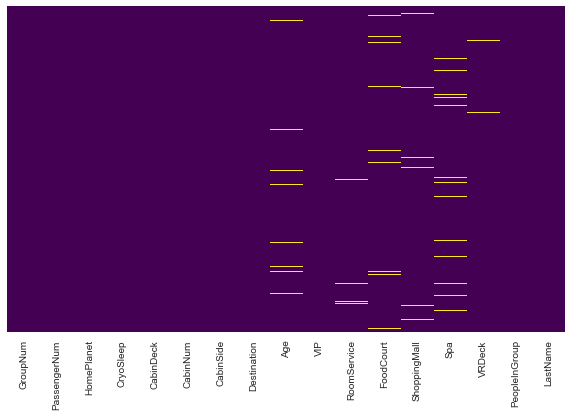

In [56]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data4.isnull(), yticklabels=False, cmap='viridis', cbar=False)

### Missing Age

In [57]:
data4.loc[(data4['VIP'] == True) & (data4['Age'].isna()), 'Age'] = round(data4.loc[data4['VIP'] == True, 'Age'].dropna().mean())

In [58]:
data4.loc[(data4['VIP'] == False) & (data4['Age'].isna()), 'Age'] = round(data4.loc[data4['VIP'] == False, 'Age'].dropna().mean())

<AxesSubplot:>

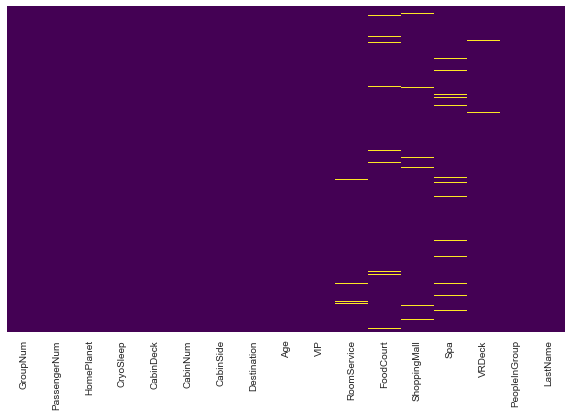

In [59]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data4.isnull(), yticklabels=False, cmap='viridis', cbar=False)

### Missing Amenities

In [60]:
for col in [
    'RoomService',
    'FoodCourt',
    'VRDeck',
    'ShoppingMall',
    'Spa'
]:
    data4[col].fillna(data4[col].mean(), inplace=True)

<AxesSubplot:>

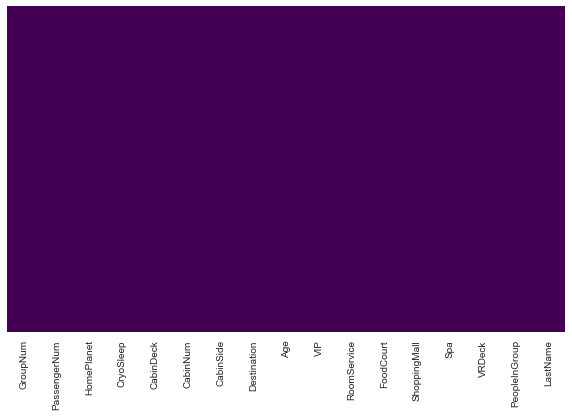

In [61]:
plt.figure(figsize=(10, 6))
sns.heatmap(data=data4.isnull(), yticklabels=False, cmap='viridis', cbar=False)

In [62]:
data5 = data4.copy()

## Further Feature Transformations

In [63]:
data5['CabinNum'] = data5['CabinNum'].astype(np.int)

In [64]:
for col in data5.select_dtypes(np.number).skew()[data5.select_dtypes(np.number).skew() > 0.5].index:
    data5[col] = np.log1p(data5[col])

In [65]:
data5.select_dtypes(np.number).skew()

GroupNum         0.001741
PassengerNum     1.836905
CabinNum        -1.074143
Age              0.443505
RoomService      1.030436
FoodCourt        1.017876
ShoppingMall     1.095306
Spa              1.006143
VRDeck           1.093721
PeopleInGroup    1.146030
dtype: float64

In [66]:
data6 = data5.copy()

## Encoding

In [69]:
data6.drop('LastName', axis=1, inplace=True)

In [74]:
data6 = pd.get_dummies(data6, drop_first=True)

## Scaling

In [75]:
scaler = StandardScaler()

In [76]:
scaler.fit(data6)

StandardScaler()

In [77]:
data7 = pd.DataFrame(scaler.transform(data6), index=data6.index, columns=data6.columns)

In [78]:
data7.head()

,GroupNum,PassengerNum,CryoSleep,CabinNum,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PeopleInGroup,HomePlanet_Europa,HomePlanet_Mars,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinSide_S,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
0,-1.725496,-0.556538,-0.778072,-4.583327,0.717998,-0.160823,-0.671714,-0.683700,-0.661225,-0.697615,-0.666900,-0.760413,1.756428,-0.515616,3.189264,-0.307733,-0.244214,-0.338592,-0.720233,-0.646252,-0.029135,-0.996767,-0.316951,0.646731
1,-1.725123,-0.556538,-0.778072,-4.583327,-0.335620,-0.160823,1.032438,0.088870,0.584088,1.550272,0.700298,-0.760413,-0.569337,-0.515616,-0.313552,-0.307733,-0.244214,-0.338592,1.388440,-0.646252,-0.029135,1.003244,-0.316951,0.646731
2,-1.724751,-0.556538,-0.778072,-4.583327,2.052581,6.218007,0.700238,2.061641,-0.661225,2.441718,0.738139,0.220593,1.756428,-0.515616,-0.313552,-0.307733,-0.244214,-0.338592,-0.720233,-0.646252,-0.029135,1.003244,-0.316951,0.646731
3,-1.724751,0.764721,-0.778072,-4.583327,0.296551,-0.160823,-0.671714,1.717883,1.601101,2.191804,1.225100,0.220593,1.756428,-0.515616,-0.313552,-0.307733,-0.244214,-0.338592,-0.720233,-0.646252,-0.029135,1.003244,-0.316951,0.646731
4,-1.724379,-0.556538,-0.778072,-4.040775,-0.897549,-0.160823,1.400986,0.746526,1.259008,1.560487,-0.272323,-0.760413,-0.569337,-0.515616,-0.313552,-0.307733,-0.244214,-0.338592,1.388440,-0.646252,-0.029135,1.003244,-0.316951,0.646731


## Preparing DataFrames for Models

In [79]:
train1 = pd.concat([data7.loc[train0.index], target0], axis=1)

In [80]:
test1 = data7.loc[data7.index[train0.index.max() + 1:]]

## Model Selection

In [81]:
setup_var = setup(data=train1, target='Transported')

,Description,Value
0,session_id,8286
1,Target,Transported
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(8693, 25)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,14
8,Ordinal Features,False
9,High Cardinality Features,False


In [82]:
models = compare_models(n_select=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8046,0.8961,0.7926,0.8122,0.8019,0.6092,0.6098,0.0750
gbc,Gradient Boosting Classifier,0.7997,0.8942,0.8236,0.7860,0.8042,0.5994,0.6004,0.3290
rf,Random Forest Classifier,0.7926,0.8775,0.7479,0.8211,0.7826,0.5852,0.5878,0.3410
ada,Ada Boost Classifier,0.7911,0.8796,0.8190,0.7757,0.7964,0.5823,0.5838,0.1120
et,Extra Trees Classifier,0.7849,0.8577,0.7242,0.8238,0.7706,0.5697,0.5741,0.3080
ridge,Ridge Classifier,0.7722,0.0000,0.7712,0.7725,0.7717,0.5445,0.5447,0.0100
lda,Linear Discriminant Analysis,0.7722,0.8465,0.7716,0.7723,0.7718,0.5445,0.5447,0.0160
lr,Logistic Regression,0.7709,0.8471,0.7762,0.7678,0.7718,0.5418,0.5421,0.7760
svm,SVM - Linear Kernel,0.7568,0.0000,0.7817,0.7476,0.7620,0.5136,0.5182,0.0260
knn,K Neighbors Classifier,0.7512,0.8238,0.7192,0.7679,0.7425,0.5023,0.5036,0.0970


## Baseline Model

In [99]:
baseline_model = LGBMClassifier()

In [100]:
baseline_model.fit(train1.drop('Transported', axis=1), train1['Transported'])

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [101]:
predictions = baseline_model.predict(test1)

In [102]:
predictions

array([ True, False,  True, ...,  True, False,  True])

## Ensembling

In [108]:
predictions = {}

In [106]:
models = {
    'lightbgm': LGBMClassifier(),
    'gbc': GradientBoostingClassifier(),
    'rf': RandomForestClassifier(),
    'ada': AdaBoostClassifier(),
    'et': ExtraTreesClassifier()
}

In [109]:
for name, model in models.items():
    model.fit(train1.drop('Transported', axis=1), train1['Transported'])
    predictions[name] = model.predict(test1)

In [119]:
final_pred = []
for i in range(0, 4277):
    a = 0
    for name, model in models.items():
        if predictions[name][i] == True:
            a += 1
    
    if a >= 3:
        final_pred.append(True)
    else:
        final_pred.append(False)

In [121]:
len(final_pred)

4277

## Submission

In [125]:
submission = pd.Series(final_pred, index=test0['PassengerId'], name='Transported', dtype=str)

In [126]:
submission

PassengerId
0013_01     True
0018_01    False
0019_01     True
0021_01     True
0023_01     True
           ...  
9266_02     True
9269_01    False
9271_01     True
9273_01     True
9277_01     True
Name: Transported, Length: 4277, dtype: object

In [127]:
submission.to_csv('submission003.csv')